In [20]:
import os
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import transformers
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaModel
from transformers import BertTokenizer, pipeline
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import Adam
import time
import json
import spacy


import random
from collections import Counter, defaultdict
import numpy as np
from sample_few_shot import get_label_dict
from finetune_model import RobertaNER, BertNER
from eval_util import batch_span_eval
from data import *
from torch.utils.tensorboard import SummaryWriter

In [21]:
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [22]:
def generate_batch(batch):
    text = [F.pad(torch.tensor(x[0]), (0,max_seq_len-len(x[0])), "constant", 1) for x in batch] # batch_size * max_seq_len 
    text = pad_sequence(text, batch_first = True)
    attention_mask = [torch.cat((torch.ones_like(torch.tensor(x[0])), torch.zeros(max_seq_len-len(x[0]), dtype=torch.int64)), dim=0)
        if len(x[0]) < max_seq_len else torch.ones_like(torch.tensor(x[0]))[:max_seq_len] for x in batch]
    attention_mask = pad_sequence(attention_mask, batch_first = True)
    label = [F.pad(torch.tensor(x[1]), (0,max_seq_len-len(x[1])), "constant", -100) for x in batch]
    label = pad_sequence(label, batch_first = True)
    orig_len = [len(x[0]) for x in batch]

    return text, attention_mask, label, orig_len

In [23]:
class Args:
    def __init__(self):
        i = 0
        self.datapath = 'dataset'
        self.dataset = 'custom'
        self.train_text = f'FS_train_dataset{i}.words'
        self.train_ner = f'FS_train_dataset{i}.ner'
        self.test_text = f'FS_test_dataset{i}.words'
        self.test_ner = f'FS_test_dataset{i}.ner'
        self.model_save_name = f'FS_train_dataset{i}_finetuned_model'
        self.few_shot_sets = 1
        self.unsup_text = None
        self.unsup_ner = None
        self.base_model = 'roberta'
        self.epoch = 5
        self.train_cls_num = 4
        self.test_cls_num = 18
        self.max_seq_len = 128
        self.batch_size = 8
        self.soft_kmeans = False
        self.lr = 1e-04
        self.unsup_lr = 0.5
        self.warmup_proportion = 0.1
        self.weight_decay = 0.01
        self.use_truecase = False
        self.local_rank = None
        self.use_gpu = 'cuda'
        self.data_size = ''
        self.load_model = True
        self.reinit = False
        self.load_model_name = 'pretrained_models/lc_pretrained_190.pt'
        self.load_checkpoint = False
        self.load_dataset = False
        self.train_dataset_file = None
        self.test_dataset_file = None
        self.label2ids = None
        self.id2labels = None

args = Args()

In [24]:
label2id = {'O': 0,
 'B-Company_Name': 1,
 'I-Company_Name': 2,
 'B-Internal_Organization': 3,
 'I-Internal_Organization': 4,
 'B-Software_Name': 5,
 'I-Software_Name': 6,
 'B-Userbase_Information': 7,
 'I-Userbase_Information': 8,
 'B-Software_Purpose': 9,
 'I-Software_Purpose': 10,
 'B-Development_Scalability': 11,
 'I-Development_Scalability': 12,
 'B-Transaction_Scalability': 13,
 'I-Transaction_Scalability': 14,
 'B-Data_Scalability': 15,
 'I-Data_Scalability': 16}

In [25]:
id2label = {0: 'O',
 1: 'B-Company_Name',
 2: 'I-Company_Name',
 3: 'B-Internal_Organization',
 4: 'I-Internal_Organization',
 5: 'B-Software_Name',
 6: 'I-Software_Name',
 7: 'B-Userbase_Information',
 8: 'I-Userbase_Information',
 9: 'B-Software_Purpose',
 10: 'I-Software_Purpose',
 11: 'B-Development_Scalability',
 12: 'I-Development_Scalability',
 13: 'B-Transaction_Scalability',
 14: 'I-Transaction_Scalability',
 15: 'B-Data_Scalability',
 16: 'I-Data_Scalability'}

In [26]:
# Data preparation 
test_text = os.path.join(args.datapath, args.dataset, args.test_text)

with open(test_text, encoding='utf-8') as f:
    test_words = f.readlines()     

    
# Making dummy tags
test_ner_tags = []
for t in test_words:
    word_list = t.split()
    tags = " ".join(["O"] * len(word_list))
    tags = tags + "\n"
    test_ner_tags.append(tags)


# The tokenizer for roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')    
    
# Getting the labell ids
label2ids, id2labels = [], []
processed_test_set, test_label_sentence_dicts = [], []

label2ids.append(label2id)
id2labels.append(id2label)

#Keeping track of the unprocessed data
unprocessed_test_ner_tags = test_ner_tags
unprocessed_test_words = test_words


# Processesing data to input into model
max_seq_len = args.max_seq_len
test_ner_tags, test_words, test_label_sentence_dict = process_data(test_ner_tags, test_words, tokenizer, label2id, max_seq_len,base_model=args.base_model,use_truecase=args.use_truecase)


sub_valid_ = [[test_words[i], test_ner_tags[i]] for i in range(len(test_ner_tags))] 

processed_test_set.append(sub_valid_) 


dataset_label_nums = [len(x) for x in label2ids]
test_num_data_point = sum([len(sub_valid_) for sub_valid_ in processed_test_set])

In [27]:
dataset_label_nums

[17]

In [28]:
# Importing the fine-tuned model
new_model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums=dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
new_model = torch.nn.DataParallel(new_model)
i = 0
new_model.load_state_dict(torch.load(os.path.join("trained_model",f"FS_train_dataset{i}_finetuned_model_dict.pt")))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaNER were not initialized from the model checkpoint at roberta-base and are newly initialized: ['background', 'classifier.weight', 'classifier.bias', 'classifiers.0.weight', 'classifiers.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for p

<All keys matched successfully>

In [29]:
def get_predictions(data_):
    dataset_chosen = []
    data = []
    for i,d in enumerate(data_):
        one_dataset = [generate_batch(d)]
        data.extend(one_dataset)
        dataset_chosen.extend([i for x in range(len(one_dataset))])
        
    idx = 0
    f1ss = []
    pss = []
    rss = []
    
    
    new_model.eval()
    
    for j, (text, attention_mask, cls, orig_len) in enumerate(data):
        with torch.no_grad():
            text_1, attention_mask_1, cls_1 = text.to(device), attention_mask.to(device).to(device), cls.to(device)
            loss, outputs = new_model(text_1, attention_mask=attention_mask_1, labels=cls_1, dataset = dataset_chosen[j])
        preds = [[id2label[int(x)] for j,x in enumerate(y[1:orig_len[i]-1]) if int(cls[i][j + 1]) != -100] for i,y in enumerate(outputs)]
        gold = [[id2label[int(x)] for x in y[1:orig_len[i]-1] if int(x) != -100] for i,y in enumerate(cls)]
    
    return preds, gold

In [30]:
pred, original = get_predictions(processed_test_set)

In [31]:
len(unprocessed_test_words[0].split())

23

In [32]:
pred[0]

['B-Company_Name',
 'I-Company_Name',
 'O',
 'O',
 'O',
 'O',
 'B-Software_Purpose',
 'B-Internal_Organization',
 'I-Internal_Organization',
 'I-Internal_Organization',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [33]:
def find_entities(labels):
    entities = {}
    start_idx = None

    for idx, label in enumerate(labels):
        if label.startswith('B-'):
            # Found the start of an entity
            if start_idx is not None:
                # Add the previous entity to the dictionary
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
            
            start_idx = idx
        elif label.startswith('I-'):
            # Continue the current entity
            if start_idx is None:
                start_idx = idx
        else:
            # End of entity
            if start_idx is not None:
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
                start_idx = None

    # Check if there's an entity that spans till the end of the list
    if start_idx is not None:
        entity = labels[start_idx].split('-')[1]
        entities[entity] = entities.get(entity,[]) + [list(range(start_idx, len(labels)))]

    return entities

In [34]:
sentence = unprocessed_test_words[0]
prediction = pred[0]

In [35]:
nlp = spacy.load('en_core_web_sm')

# Function to retrieve graph nodes based of the entities, in the process we also use lemmatization from spaCy
def get_graph_nodes(sentence,nlp,prediction):
    # Using lemmatization on all the words in the sentence
    doc = nlp(sentence)
    lem_dict = {}
    for token in doc:
        lem_dict[token.text] = token.lemma_
        
    # Retriving the indices of the predictions
    entity_pos = find_entities(prediction)
    node_dict = {}

    s_tokens = sentence.split()
    lem_keys = lem_dict.keys()
    for e in entity_pos:
        for idx in entity_pos[e]:
            token = ""
            token2 = ""
            for i in idx:
                temp  = s_tokens[i]
                if temp in lem_keys:
                    token = token +" "+ lem_dict[temp]
                else:
                    token = token +" "+ temp
                # Keeping track of the the original (no lemmatization)
                token2 = token2 +" "+ temp
                
            node_list = node_dict.get(e,[])
            node_dict[e] = node_list +[token.strip()]
            
            e_original = e+"_original"
            node_list = node_dict.get(e_original,[])
            node_dict[e_original] = node_list +[token2.strip()]
            
    node_dict['full_sentence'] = sentence
    node_dict['full_predictions'] = prediction
    node_dict['all_entities'] = list(entity_pos.keys())
    return node_dict


In [36]:
get_graph_nodes(sentence,nlp,prediction)

{'Company_Name': ['ALLDATA provide'],
 'Company_Name_original': ['ALLDATA provides'],
 'Software_Purpose': ['connect'],
 'Software_Purpose_original': ['connect'],
 'Internal_Organization': ['automotive repair technician'],
 'Internal_Organization_original': ['automotive repair technicians'],
 'full_sentence': 'ALLDATA provides innovative software solutions that connect automotive repair technicians with the diagnostic and repair information they need from original equipment manufacturers (OEMs).\n',
 'full_predictions': ['B-Company_Name',
  'I-Company_Name',
  'O',
  'O',
  'O',
  'O',
  'B-Software_Purpose',
  'B-Internal_Organization',
  'I-Internal_Organization',
  'I-Internal_Organization',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'all_entities': ['Company_Name', 'Software_Purpose', 'Internal_Organization']}

In [37]:
all_inputs = []
for i, s in enumerate(unprocessed_test_words):
    result = get_graph_nodes(s,nlp,pred[i])
    all_inputs.append(result)

In [21]:
I need to keep track of the original tokens as well, not just the lemmatized ones.


SyntaxError: invalid syntax (4067567786.py, line 1)

In [38]:
all_inputs

[{'Company_Name': ['ALLDATA provide'],
  'Company_Name_original': ['ALLDATA provides'],
  'Software_Purpose': ['connect'],
  'Software_Purpose_original': ['connect'],
  'Internal_Organization': ['automotive repair technician'],
  'Internal_Organization_original': ['automotive repair technicians'],
  'full_sentence': 'ALLDATA provides innovative software solutions that connect automotive repair technicians with the diagnostic and repair information they need from original equipment manufacturers (OEMs).\n',
  'full_predictions': ['B-Company_Name',
   'I-Company_Name',
   'O',
   'O',
   'O',
   'O',
   'B-Software_Purpose',
   'B-Internal_Organization',
   'I-Internal_Organization',
   'I-Internal_Organization',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O'],
  'all_entities': ['Company_Name',
   'Software_Purpose',
   'Internal_Organization']},
 {'Company_Name': ['Bruker Biospin’s'],
  'Company_Name_original': ['Bruker Biospin’s'

# Visualization of Knowledge Graph

In [87]:
import networkx as nx
import matplotlib.pyplot as plt

In [152]:
G = nx.DiGraph()

In [153]:
labels_to_colours = {'Transaction_Scalability': '#64BBE2',
                      'Data_Scalability': '#64BBE2',
                      'Development_Scalability': '#64BBE2',
                      'Software_Purpose': '#F5AF58',
                      'Userbase_Information': '#F5AF58',
                      'Internal_Organization': '#F5AF58',
                      'Software_Name': '#2F5B7C',
                      'Company_Name': '#2F5B7C',
                      'Company': '#A20025',
                      'Software': '#A20025'}

In [154]:
# G.add_nodes_from([
#     (4, {"color": "red"}),
#     (5, {"color": "green"}),
# ])

In [155]:
# Constructing the graph
nodes = []
nodes.append(('Software',{"color":labels_to_colours['Software']}))
nodes.append(('Company',{"color":labels_to_colours['Company']}))

edges = []
edge_labels = {}
count = 0
for d in all_inputs:
    
    # adding all the nodes
    # iterating through all entities
    for e in d['all_entities']:
        
        # all the elements of this entity type
        for i in d[e]:
            # adding to the list of nodes
            nodes.append((i,{"color":labels_to_colours[e]}))
            
    count += 1
    if count > 5:
        break

# Add nodes to the graph
G.add_nodes_from(nodes)
    

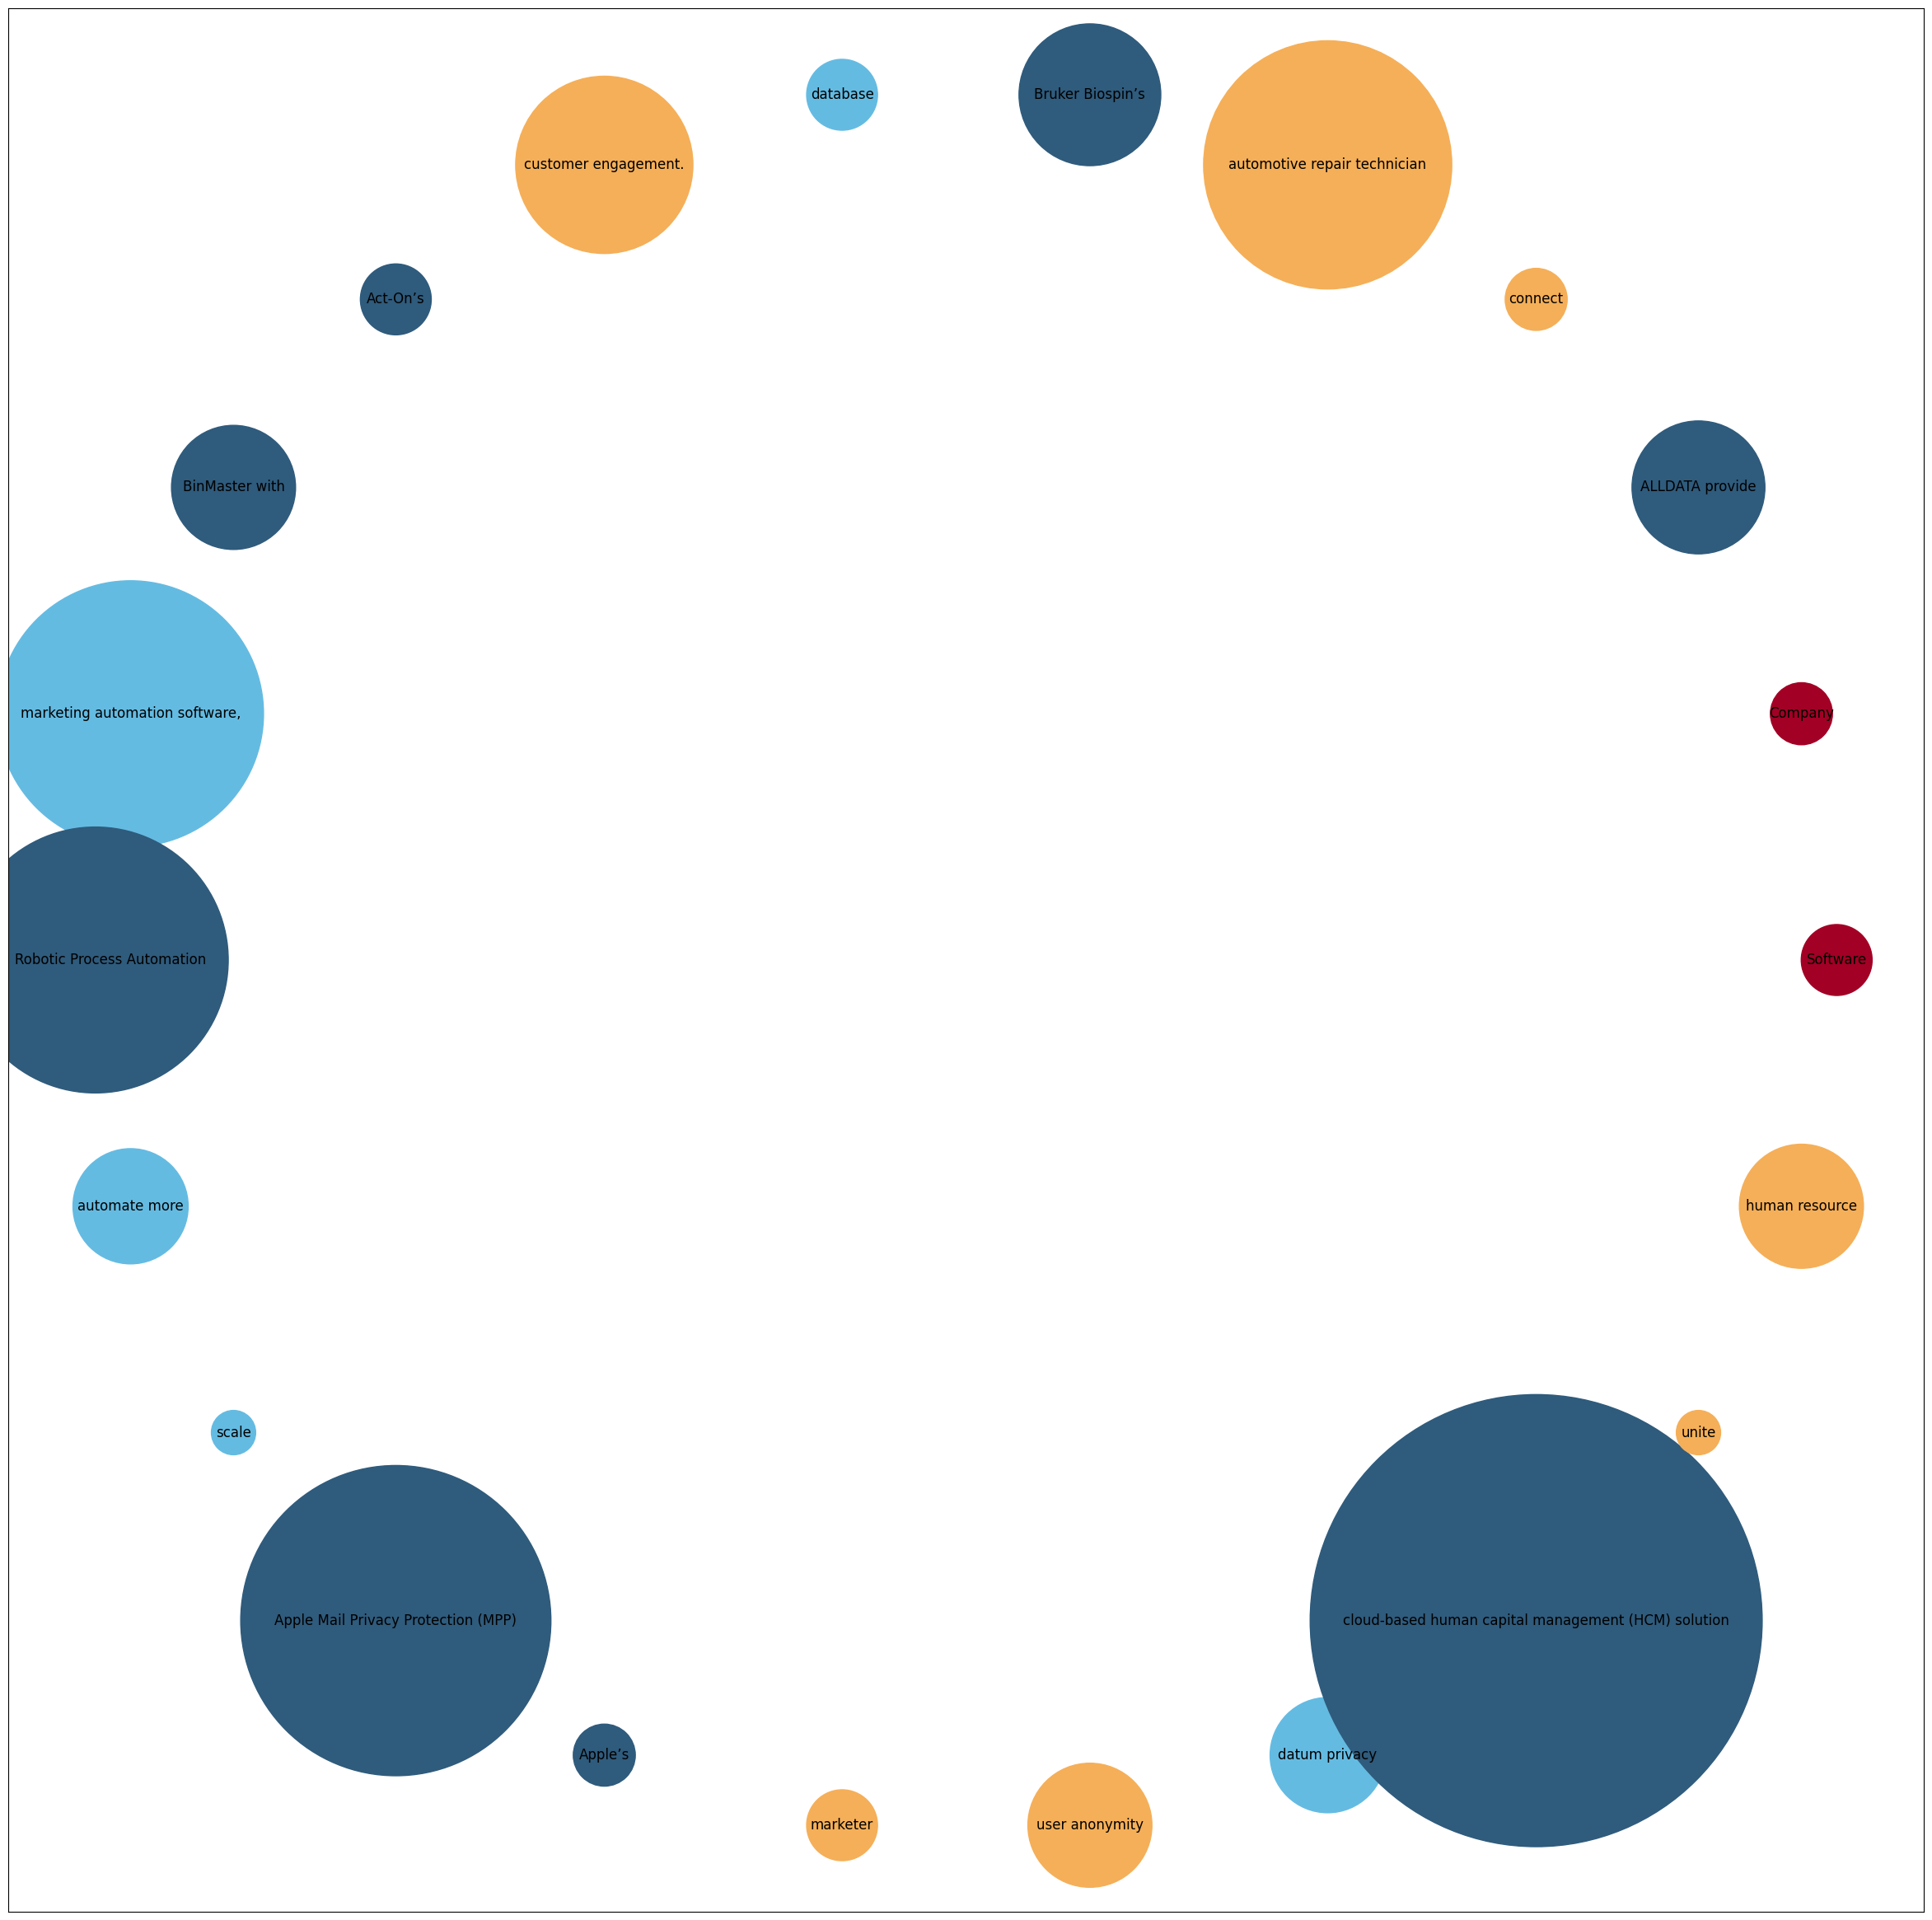

In [170]:
# Compute the positions of nodes using the Kamada-Kawai layout algorithm
positions = nx.kamada_kawai_layout(G)

# Extract the node information from the graph
nodes = list(G.nodes(data=True))

node_colors = [b['color'] for (a,b) in nodes]
labels = {node[0]: node[1].get('label', str(node[0])) for node in nodes}
node_sizes = [len(label) ** 2 * 60 for label in labels.values()]

# Plot the graph
plt.figure(figsize=(30, 30))
nx.draw_networkx(
    G,
    node_color=node_colors,
    pos=positions,
    labels=labels,
    node_size=node_sizes,
)

# Display the plot
plt.show()